# Import

In [1]:
import data_loader.data_loaders as module_loader
import os
import matplotlib.pyplot as plt
from model.model import *
import torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary as summary
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from model import loss
import model.model as module_model
import model.loss as module_loss
import model.metric as module_metric
# import logger
from trainer import Trainer
from torch.optim import lr_scheduler
from monai.losses import MaskedDiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNet, RegUNet, AttentionUnet

In [2]:
train_data_loader =\
    module_loader.MultiClassSegmentationLoader(
        os.getcwd()+'/data/plant', 
        num_classes=4,
        batch_size=10, 
        mode='train') # binary dataset
    
valid_data_loader = \
    module_loader.MultiClassSegmentationLoader(
        os.getcwd()+'/data/plant', 
        num_classes=4,
        batch_size=10, 
        mode='valid')

/home/hklee/workspace/torch-project/data/plant/images/train /home/hklee/workspace/torch-project/data/plant/masks/train
/home/hklee/workspace/torch-project/data/plant/images/valid /home/hklee/workspace/torch-project/data/plant/masks/valid


In [3]:
for img ,mask in train_data_loader:
    print(img.shape)
    print(img.dtype)
    print(mask.shape)
    print(mask.dtype)
    break

torch.Size([10, 3, 240, 240])
torch.float32
torch.Size([10, 4, 240, 240])
torch.int64


model.py -> BaseModel 상속으로 바꾸고 학습되는지 보기

In [4]:
# model = U_Net(img_ch=3, output_ch=4).to(device)
	  
model = UNet(
    spatial_dims= 2,
    in_channels=3,
    out_channels=4,
    channels=[64,128,256,512],
    strides=[1,1,1]
).to(device)
summary(model, (3, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           1,792
    InstanceNorm2d-2         [-1, 64, 240, 240]               0
           Dropout-3         [-1, 64, 240, 240]               0
             PReLU-4         [-1, 64, 240, 240]               1
            Conv2d-5        [-1, 128, 240, 240]          73,856
    InstanceNorm2d-6        [-1, 128, 240, 240]               0
           Dropout-7        [-1, 128, 240, 240]               0
             PReLU-8        [-1, 128, 240, 240]               1
            Conv2d-9        [-1, 256, 240, 240]         295,168
   InstanceNorm2d-10        [-1, 256, 240, 240]               0
          Dropout-11        [-1, 256, 240, 240]               0
            PReLU-12        [-1, 256, 240, 240]               1
           Conv2d-13        [-1, 512, 240, 240]       1,180,160
   InstanceNorm2d-14        [-1, 512, 2

In [5]:
# init
EPOCHS = 10
epoch_loss_values = list()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = getattr(module_loss, 'cross_entropy')
optimizer = optim.Adam(list(model.parameters()), 1e-5)
val_interval = 5

In [6]:
for epoch in range(EPOCHS, EPOCHS+20):
    epoch_loss = 0.0
    
    model.train() # switch to train mode
    for step, batch in enumerate(tqdm(train_data_loader)):
        inputs, labels = batch
        # inputs = inputs.type('torch.FloatTensor')
        # labels = labels.type('torch.FloatTensor')
        inputs = inputs.to(device)
        labels = labels.to(device) 

        # forward + backward + optimizer 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels) # loss 계산
        
        optimizer.zero_grad() # gradient(변화도) 0으로 만들고
        loss.backward() # 역전파
        optimizer.step()

        epoch_loss += loss.item()
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0 :
        model.eval()
        with torch.no_grad():
            print('check interval!')
        
print("finished")


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10, 4, 240, 240]) torch.Size([10, 1, 4, 240, 240])


RuntimeError: Expected floating point type for target with class probabilities, got Long

### Trainer
```
trainer init
    def __init__(self, model, criterion, metric_ftns, optimizer, config, device,
                 data_loader, valid_data_loader=None, lr_scheduler=None, len_epoch=None):
        super().__init__(model, criterion, metric_ftns, optimizer, config)
```

In [ ]:
# init
EPOCHS = 30
epoch_loss_values = list()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optimizer = optim.Adam(list(model.parameters()), 1e-5)
val_interval = 5
metrics = [getattr(module_metric, 'dice')]

In [ ]:
# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95**epoch)

trainer = Trainer(model, criterion, metrics, optimizer,
                    config=config,
                    device=device,
                    data_loader=train_data_loader,
                    valid_data_loader=valid_data_loader,
                    lr_scheduler=lr_scheduler)

trainer.train()


### Inference

In [ ]:
test_loader = get_loader('./data/plant', mode='test', batch_size=10)
for i in test_loader:
    print(i[0].shape)
    break

./data/plant/images/test ./data/plant/masks/test
torch.Size([10, 3, 240, 240])


In [ ]:
iter_ = iter(test_loader)
img, mask = next(iter_)
print(img.shape)
print(torch.unique(img))
print(mask.shape)
print(torch.unique(mask))

torch.Size([10, 3, 240, 240])
tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.

In [ ]:
for img, mask in test_loader:
    img = img.to(device)
    # outputs = model(img)
    break

In [ ]:
outputs = outputs.to('cpu')
outputs = torch.sigmoid(outputs)
outputs = (outputs > 0.5).float()

In [ ]:
numpy_outputs = outputs.to('cpu').detach().numpy()
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = outputs[i, :, :, :].squeeze()
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()

In [ ]:
file_name = 'monai_unet_epoch30_loss(Dice).png'
torchvision.utils.save_image(outputs, f'./saved/{file_name}', nrow=5)

In [ ]:
img = img.to('cpu')
img = img.detach().numpy()

In [ ]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = img[i, :, :, :].squeeze()
    result = result.transpose(1,2,0)
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()


In [ ]:
mask = mask.to('cpu').detach().numpy()
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = mask[i, :, :].squeeze()
    # result = result.transpose(1,2,0)
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()

# Monai Test

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNet, RegUNet, AttentionUnet

model = UNet(
    spatial_dims= 2,
    in_channels=3,
    out_channels=1,
    channels=[64,128,256,512],
    strides=[1,1,1]
)

In [ ]:
model = SwinUNETR(
        img_size=(96, 96, 96),
        in_channels=3,
        out_channels=4,
        feature_size=48
    )

In [ ]:
a = np.zeros(shape=(240,240))

In [ ]:
t = torch.tensor(a)
t.shape
t = torch.unsqueeze(t, 0)
t.shape

In [ ]:
model.to(device)

In [ ]:
summary(model, (3, 240, 240))

# Dataset, DataLoader

In [ ]:
from data_loader.dataset import SegmentationDataset, MultiClassSegmentationDataset
from data_loader.data_loaders import SegmentationLoader, get_loader
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_loader = SegmentationLoader(data_dir = './data',
                                   batch_size = 10,
                                   mode='train',
                                   image_size=240)

./data/images/train ./data/masks/train


In [ ]:
iter_ = iter(train_loader)
data=  next(iter_)

In [ ]:
image, mask = data
print(type(image))
print(image.dtype)
print(image.shape)
print(type(mask))
print(mask.dtype)
print(mask.shape)
torch.unique(mask)


<class 'torch.Tensor'>
torch.float32
torch.Size([10, 3, 240, 240])
<class 'torch.Tensor'>
torch.float32
torch.Size([10, 1, 240, 240])


tensor([0., 1., 2., 3.])

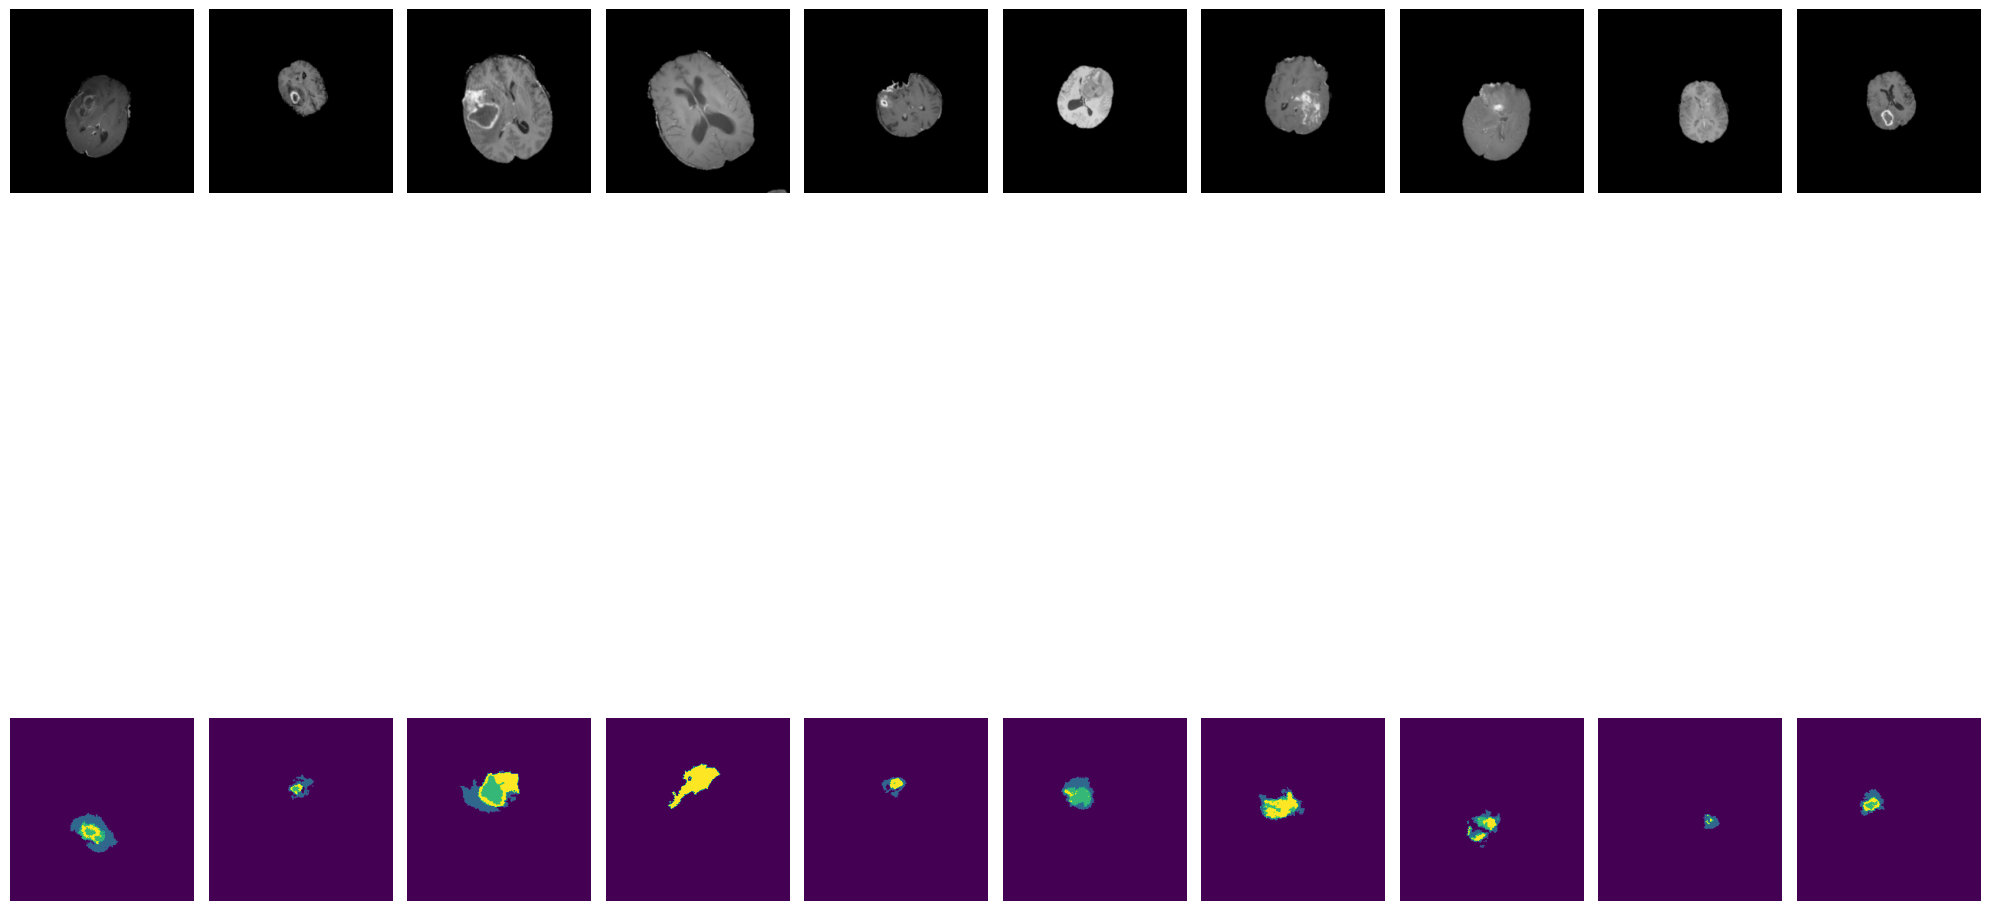

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 10, figsize=(20,20))

for i in range(10):
    ax1[i].imshow(image[i, :, :, :].permute(1,2,0))
    ax2[i].imshow(mask[i,0,:,:])
    ax1[i].axis('off')
    ax2[i].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
from data_loader.augmentation import get_train_augmentation, get_valid_augmentation
from PIL import Image

class TestDataset(SegmentationDataset):
    def __init__(self, data_path, mode='train', image_size=240):
        super().__init__(data_path, mode, image_size)
        
    def __getitem__(self, idx):
        image_path = self.images[idx]
        filename = image_path.split('/')[-1].replace('jpg', 'png')
        mask_path = os.path.join(self.mask_path, filename)

        image = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)

        # 전처리, augmentation
        augmentation = self.aug(image=image, mask=mask)
        image = augmentation['image'] / 255.0
        mask = augmentation['mask']
        mask[mask == 255.0] = 1.0   
        mask = mask.unsqueeze(0)
        return image, mask

In [ ]:
brain = TestDataset('./data', 'val', 240)
img, mask = brain.__getitem__(5)
print(img.shape)
print(mask.shape)

./data/images/val ./data/masks/val
[0. 1. 2. 3.]
torch.Size([3, 240, 240])
torch.Size([1, 240, 240])


In [80]:
class MultiClassSegmentationDataset(SegmentationDataset):
    def __init__(self, data_path, mode='train', image_size=240):
        super().__init__(data_path=data_path,
                         mode=mode,
                         image_size=image_size)
        
    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        mask = mask.squeeze().to(torch.int64)
        mask = F.one_hot(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [81]:
brain_dataset = MultiClassSegmentationDataset(data_path='./data',
                                            mode='train',
                                            image_size=240)
img, mask = brain_dataset.__getitem__(5)
print(img.shape)
print(mask.shape)


./data/images/train ./data/masks/train
torch.Size([3, 240, 240])
torch.Size([4, 240, 240])


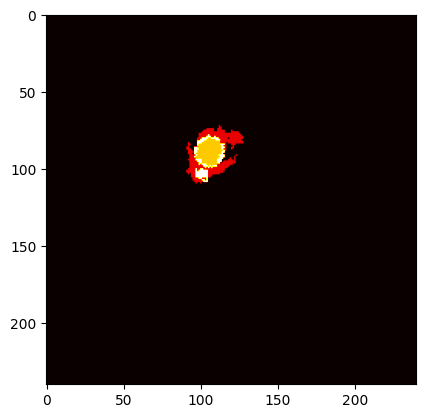

In [83]:
argmax_mask = torch.argmax(mask, dim=0)
plt.imshow(argmax_mask, cmap='hot')

# Multiclass sementic segmentation

In [ ]:
import torch

In [57]:
cls_one = torch.tensor([[0,0,0], [0,1,0],[0,1,0]])
print(cls_one.shape)
cls_two = torch.tensor([[1,1,1], [0,0,0], [0,0,0]])
print(cls_two.shape)
cls_three = torch.tensor([[0,0,0], [1,0,0], [1,0,0]])
print(cls_three.shape)
cls_four = torch.tensor([[0,0,0], [0,0,1], [0,0,1]])
print(cls_four.shape)
sample_mask = torch.stack([cls_one, cls_two, cls_three, cls_four])
print(sample_mask.shape)

torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([4, 3, 3])


In [58]:
argmax_mask = torch.argmax(sample_mask, dim=0)
argmax_mask

tensor([[1, 1, 1],
        [2, 0, 3],
        [2, 0, 3]])

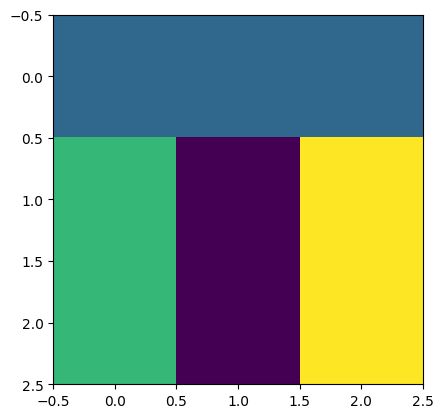

In [59]:
plt.imshow(argmax_mask)

In [60]:
m = torch.nn.functional.one_hot(argmax_mask)
preprocessed_m = m.permute(2,0,1)
print(preprocessed_m.shape)
preprocessed_m

torch.Size([4, 3, 3])


tensor([[[0, 0, 0],
         [0, 1, 0],
         [0, 1, 0]],

        [[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 1]]])

In [79]:
preprocessed_m.shape

torch.Size([4, 3, 3])